In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import math
import io

In [10]:
template_dir = 'templates/'
map_dir = 'maps/'

In [3]:
from PIL import Image, ImageDraw
import gpxpy as mod_gpxpy
from PIL import Image as mod_pil_image
from PIL import ImageDraw as mod_pil_draw
import glob as mod_glob
import math as mod_math
import numpy
osm_tile_res = 256

def format_time(time_s):
    if not time_s:
        return 'n/a'
    minutes = mod_math.floor(time_s / 60.)
    hours = mod_math.floor(minutes / 60.)
    return '%s:%s:%s' % (str(int(hours)).zfill(2), str(int(minutes % 60)).zfill(2), str(int(time_s % 60)).zfill(2)) 

def get_map_suffix ():
#    return "osm-cycle"
#    return "seznam-turist"
    return "roads"


def osm_lat_lon_to_x_y_tile (lat_deg, lon_deg, zoom):
    """ Gets tile containing given coordinate at given zoom level """
    # taken from http://wiki.openstreetmap.org/wiki/Slippy_map_tilenames, works for OSM maps and mapy.cz
    lat_rad = mod_math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - mod_math.log(mod_math.tan(lat_rad) + (1 / mod_math.cos(lat_rad))) / mod_math.pi) / 2.0 * n)
    return (xtile, ytile)


def osm_get_auto_zoom_level ( min_lat, max_lat, min_lon, max_lon, max_n_tiles):
    """ Gets zoom level which contains at maximum `max_n_tiles` """
    for z in range (0,17):
        x1, y1 = osm_lat_lon_to_x_y_tile (min_lat, min_lon, z)
        x2, y2 = osm_lat_lon_to_x_y_tile (max_lat, max_lon, z)
        max_tiles = max (abs(x2 - x1), abs(y2 - y1))
        if (max_tiles > max_n_tiles):
            print ("Max tiles: %d" % max_tiles)
            return z 
    return 17


class MapCreator:
    """ Class for map drawing """

    def __init__(self, min_lat, max_lat, min_lon, max_lon, z):
        """ constructor """
        x1, y1 = osm_lat_lon_to_x_y_tile (min_lat, min_lon, z)
        x2, y2 = osm_lat_lon_to_x_y_tile (max_lat, max_lon, z)
        self.x1 = min (x1, x2)
        self.x2 = max (x1, x2)
        self.y1 = min (y1, y2)
        self.y2 = max (y1, y2)
        self.w = (self.x2 - self.x1 + 1) * osm_tile_res
        self.h = (self.y2 - self.y1 + 1) * osm_tile_res
        self.z = z
        print (self.w, self.h)
        self.dst_img = mod_pil_image.new ("RGB", (self.w, self.h), 'white')

    def lat_lon_to_image_xy (self, lat_deg, lon_deg):
        """ Internal. Converts lat, lon into dst_img coordinates in pixels """
        lat_rad = mod_math.radians(lat_deg)
        n = 2.0 ** self.z
        xtile_frac = (lon_deg + 180.0) / 360.0 * n
        ytile_frac = (1.0 - mod_math.log(mod_math.tan(lat_rad) + (1 / mod_math.cos(lat_rad))) / mod_math.pi) / 2.0 * n
        img_x = int( (xtile_frac-self.x1)*osm_tile_res )
        img_y = int( (ytile_frac-self.y1)*osm_tile_res )
        return (img_x, img_y)

    def draw_track (self, gpx):
        """ Draw GPX track onto map """
        draw = mod_pil_draw.Draw (self.dst_img)
        trk = 0         # Just changes color of segment a little
        for track in gpx.tracks:
            for segment in track.segments:
                idx = 0
                x_from = 0
                y_from = 0
                for point in segment.points:
                    if (idx == 0):
                        x_from, y_from = self.lat_lon_to_image_xy (point.latitude, point.longitude)
                    else:
                        x_to, y_to = self.lat_lon_to_image_xy (point.latitude, point.longitude)
#                        draw.line ((x_from,y_from,x_to,y_to), (255,0,trk), 2)
                        draw.line ((x_from,y_from,x_to,y_to), 'black', width=2)
                        x_from = x_to
                        y_from = y_to
                    idx += 1
                trk += 32
                if (trk > 160):
                    trk = 0
                    
    def save_image(self, filename):
        print("Saving " + filename) 
        self.dst_img.save (filename)


In [4]:
def skeletize(img, dilatation_size=1):
    # Step 1: CgetStructuringElementreate an empty skeleton
    element = cv.getStructuringElement(cv.MORPH_RECT, (2*dilatation_size + 1, 2*dilatation_size+1), (dilatation_size, dilatation_size))
    skel = img.copy()

    # Repeat steps 2-4
    step = 0
    nonzero = 1
    nonzero_prev = cv.countNonZero(skel)

    while True:
        #Step 2: get the edges
        edges = cv.Canny(skel, 50, 200)
        # dilate
        dilated = cv.dilate(edges, element)
        #Step 3: Substract edges from the original image
        temp = cv.bitwise_and(skel, cv.bitwise_not(dilated))
        # If there are no white pixels left ie.. the image has been completely eroded, quit the loop
        nonzero = cv.countNonZero(temp)
        #print("step " + str(step) + " nonzero " +  str(nonzero) + " " + str(nonzero_prev))
        if step >= 5 or nonzero < 1000 or (1.0*nonzero/nonzero_prev < 0.5):
            break
        skel = temp
        nonzero_prev = nonzero
        step = step + 1

    if False:
        cm='gray'
        f, axs = plt.subplots(4,1,figsize=(100,100))
        axs[0].imshow(img, cmap=cm)
        axs[1].imshow(edges, cmap=cm)
        axs[2].imshow(dilated, cmap=cm)
        axs[3].imshow(temp, cmap=cm)
        plt.show()
    
    return skel



In [5]:
#gpx_files = mod_glob.glob (r"*.gpx")
#gpx_files = ['haifa-big.gpx']
gpx_files = ['karkur.gpx']
gpx_files = ['gaash.gpx']

In [6]:
def load_gpx(gpx_file):
    try:
            gpx = mod_gpxpy.parse(io.open(gpx_file))

            # Print some track stats
            print ('--------------------------------------------------------------------------------')
            print ('  GPX file     : %s' % gpx_file)
            start_time, end_time = gpx.get_time_bounds()
            #print('  Started       : %s' % start_time)
            #print('  Ended         : %s' % end_time)
            print('  Length        : %2.2fkm' % (gpx.length_3d() / 1000.))
            moving_time, stopped_time, moving_distance, stopped_distance, max_speed = gpx.get_moving_data()
            #print('  Moving time   : %s' % format_time(moving_time))
            #print('  Stopped time  : %s' % format_time(stopped_time))
#            print('  Max speed     : %2.2fm/s = %2.2fkm/h' % (max_speed, max_speed * 60. ** 2 / 1000.))    
            uphill, downhill = gpx.get_uphill_downhill()
            #print('  Total uphill  : %4.0fm' % uphill)
            #print('  Total downhill: %4.0fm' % downhill)
            min_lat, max_lat, min_lon, max_lon = gpx.get_bounds()
            print("  Bounds        : [%1.4f,%1.4f,%1.4f,%1.4f]" % (min_lat, max_lat, min_lon, max_lon))
            z = osm_get_auto_zoom_level (min_lat, max_lat, min_lon, max_lon, 6)
            #print("  Zoom Level    : %d" % z)


            # Create the map
            map_creator = MapCreator (min_lat, max_lat, min_lon, max_lon, z)
            #map_creator.cache_area()
            #map_creator.create_area_background()
            map_creator.draw_track(gpx)
            map_creator.save_image (gpx_file[:-4] + '.png')
            
    except Exception as e:
            mod_logging.exception(e)
            print('Error processing %s' % gpx_file)
            mod_sys.exit(1) 

    pil_image = map_creator.dst_img#.convert('RGB') 
    open_cv_image = numpy.array(pil_image) 
    # Convert RGB to BGR 
    map_orig = cv.cvtColor(numpy.array(pil_image), cv.COLOR_RGB2GRAY)
    return map_orig


In [7]:
def match_template(template_orig, scales, map_orig):

    template_skel = 255 - template_orig # invert
    template_skel = skeletize(template_skel)

    myres = []
    for scale_percent in scales:
        w, h = template_skel.shape[::-1]
        width = int(w * scale_percent / 100)
        height = int(h * scale_percent / 100)
        if(width > 0 and height > 0):
            dim = (width, height)
            template = cv.resize(template_skel, dim, interpolation = cv.INTER_AREA)
            dummy,mask = cv.threshold(template, 127, 255, cv.THRESH_BINARY)

#        methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
        methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED']
        for meth in methods:
            # print (method, width, height)
            img = map_orig.copy()
            img = 255 - img  # invert
            
            method = eval(meth)
            # Apply template Matching
            res = cv.matchTemplate(img, template, method) # , mask=mask)
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
            # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
            if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                top_left = min_loc
            else:
                top_left = max_loc
            if(max(top_left) > 0):
                res_tuple = (top_left[0], width, top_left[1], height, template, meth, min_val, max_val)
                myres.append(res_tuple)

    return myres

In [8]:
def rotation(image, angleInDegrees):
    h, w = image.shape[:2]
    img_c = (w / 2, h / 2)

    rot = cv.getRotationMatrix2D(img_c, angleInDegrees, 1)

    rad = math.radians(angleInDegrees)
    sin = math.sin(rad)
    cos = math.cos(rad)
    b_w = int((h * abs(sin)) + (w * abs(cos)))
    b_h = int((h * abs(cos)) + (w * abs(sin)))

    rot[0, 2] += ((b_w / 2) - img_c[0])
    rot[1, 2] += ((b_h / 2) - img_c[1])

    outImg = cv.warpAffine(image, rot, (b_w, b_h), flags=cv.INTER_LINEAR, borderValue=255)
    return outImg

In [12]:
templates = []
for t in ['lamed-plain.png', 'lech2.png', 'lech3.png', 'lech4.png', 'lech6.png', 'lech-square.png']:
    template = cv.imread(template_dir + t, 0)
    for angle in [0, 15, -25]:
        templates.append(rotation(template, angle))


#templates.append(cv.imread('lech.png',0))
#templates.append(cv.imread('lech-simple.png',0))
#templates.append(cv.imread('lamed.png',0))
#template_orig = cv.imread('line.png',0)
#template_orig = cv.imread('kh.png',0)

In [14]:
myres = []
map_orig = load_gpx(map_dir + 'gaash.gpx')
for template in templates:
    res = match_template(template, [35], map_orig)
    print("*...", end='')
    myres.extend(res)
print(str(len(myres)) + ' matches')

--------------------------------------------------------------------------------
  GPX file     : maps/gaash.gpx
  Length        : 436.34km
  Bounds        : [32.1802,32.2614,34.8115,34.9595]
Max tiles: 7
2048 1280
Saving maps/gaash.png
*...*...*...*...*...*...*...*...*...*...*...*...*...*...*...*...*...*...36 matches


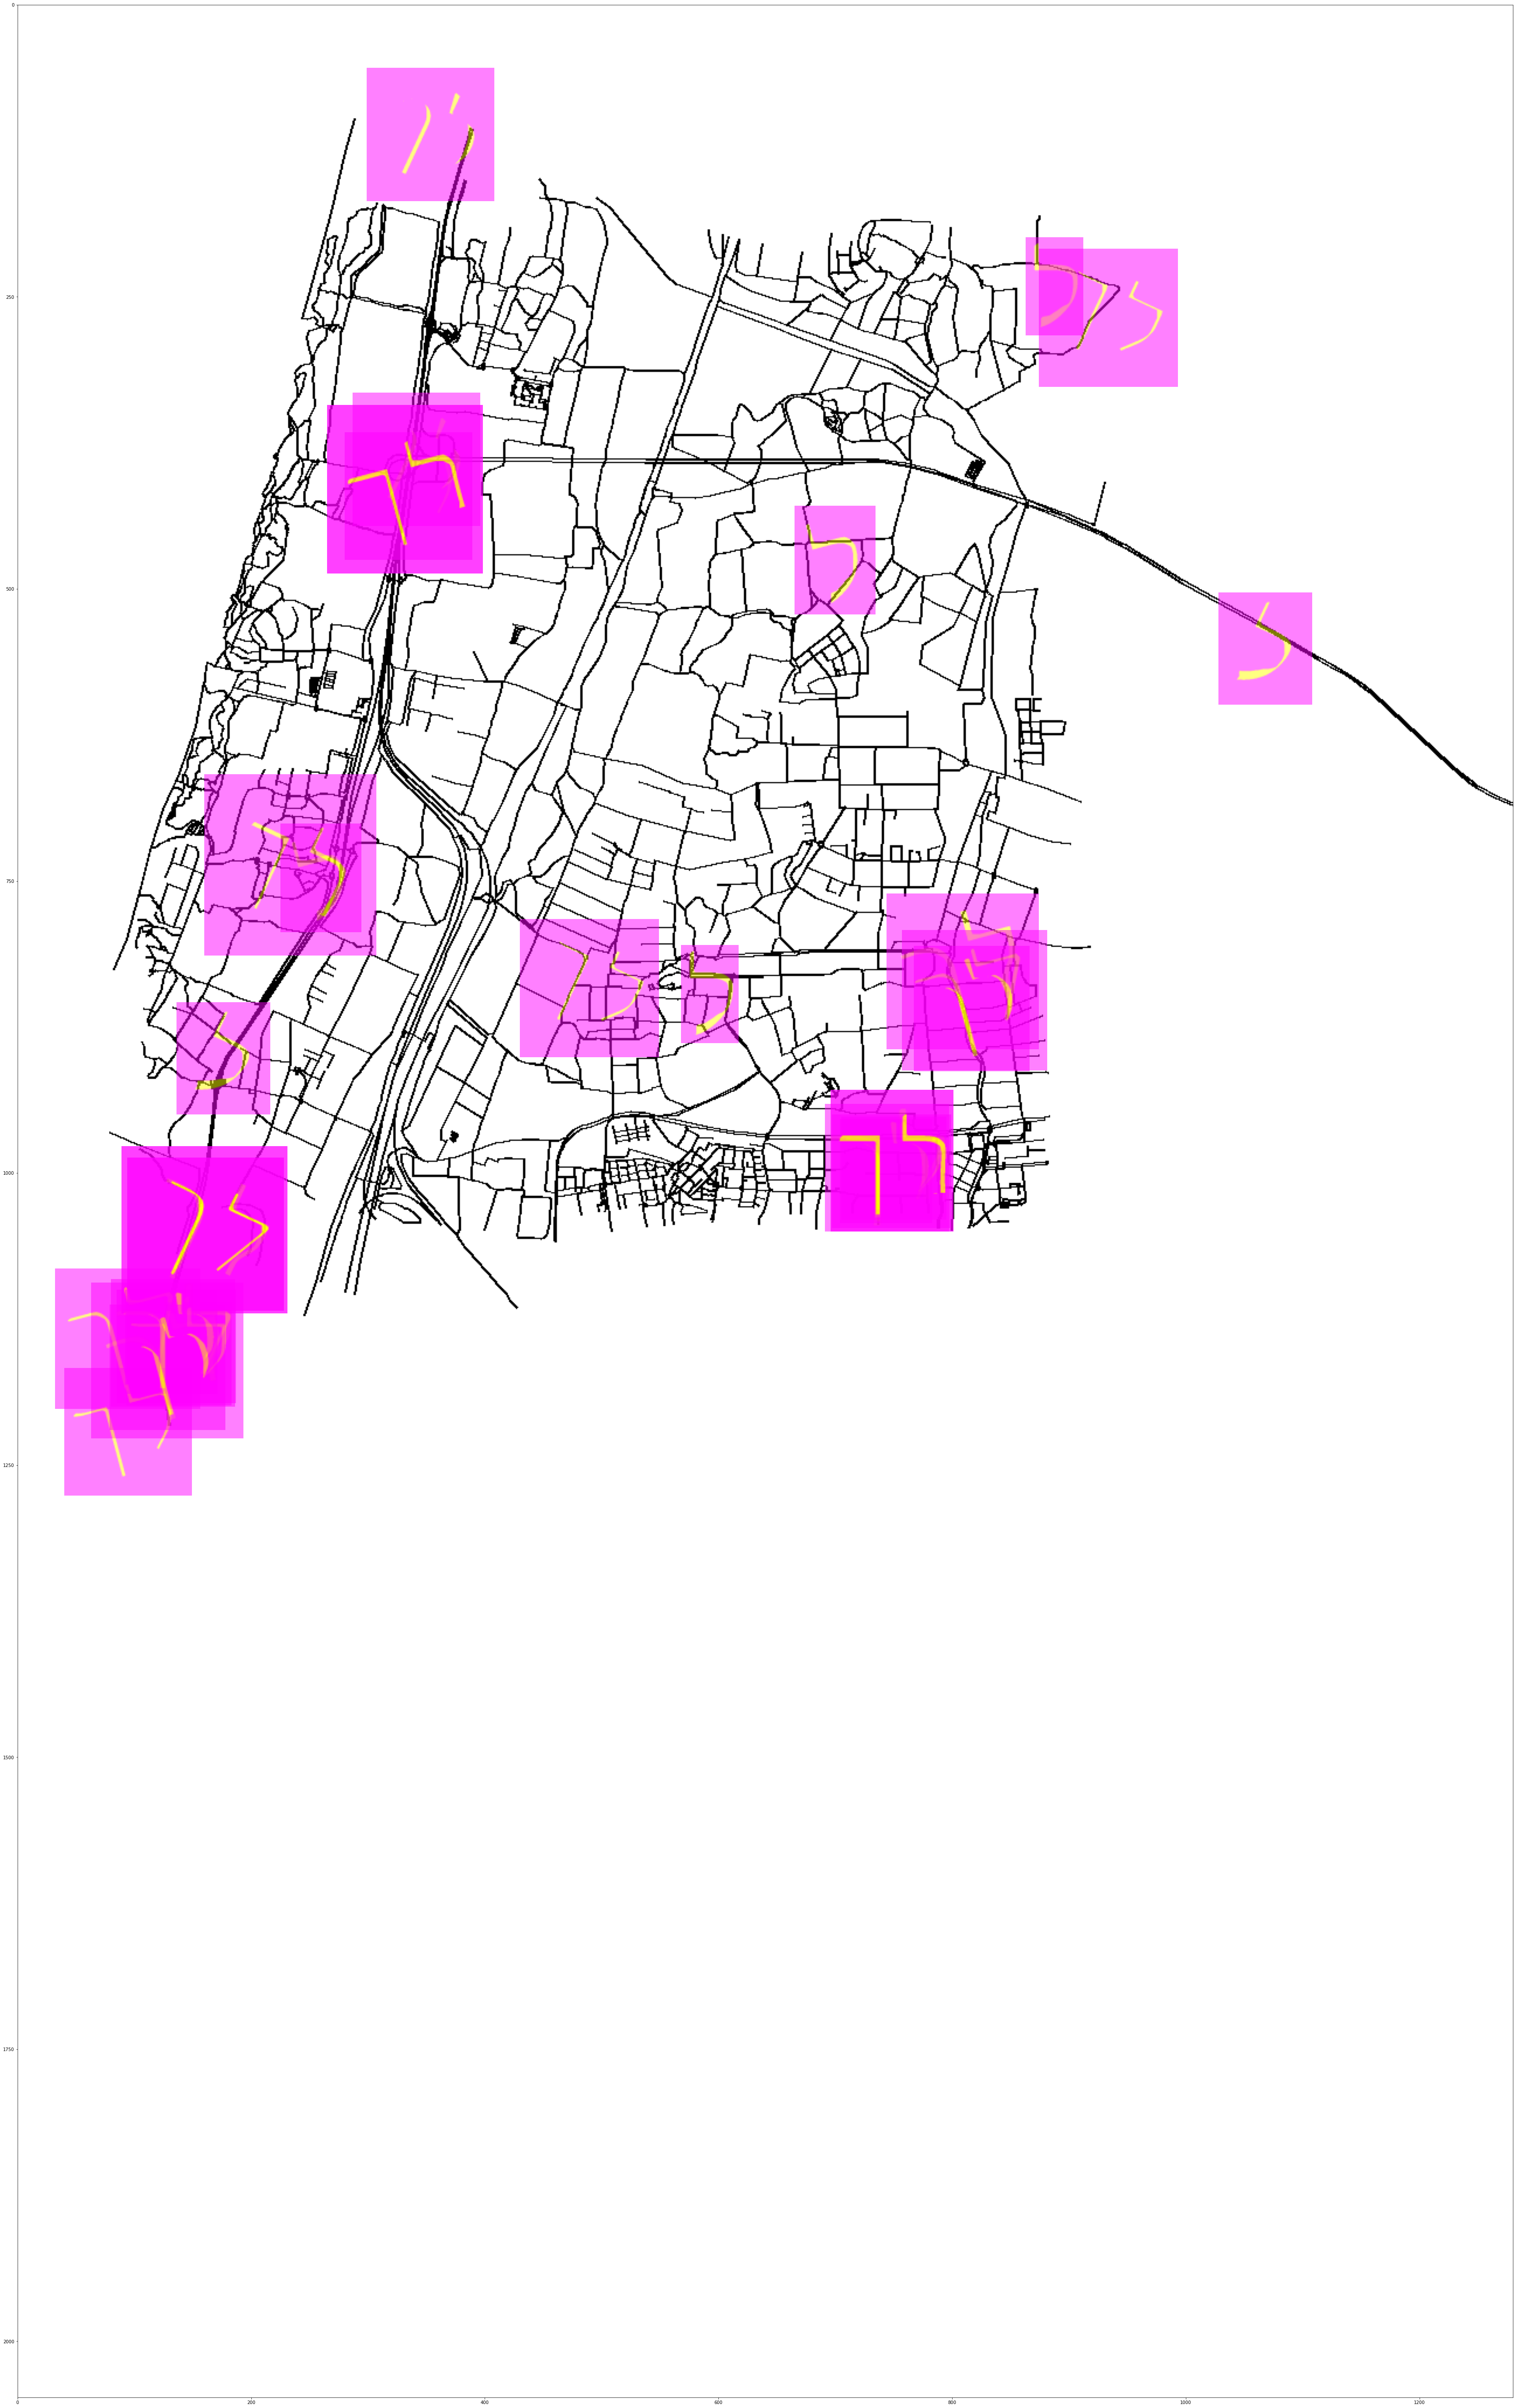

In [15]:
mm = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
if(len(myres) > 0):
    f, axs = plt.subplots(1,1,figsize=(100,100))
    #img = map_orig.copy()
    axs.set_xlim(0, map_orig.shape[0])
    axs.set_ylim(map_orig.shape[1], 0)
    axs.imshow(map_orig, cmap = 'gray')
    for r in myres:
        tlx, width, tly, height, template, method, minval, maxval = r
        if(True or method == mm[5]):
            top_left = (tlx, tly)
            bottom_right = (tlx + width, tly + height)
            #cv.rectangle(img, top_left, bottom_right, 128, cv.LINE_4)
            extent = [tlx, tlx+width, tly+height, tly]
            axs.imshow(template, cmap='spring', extent=extent, alpha=0.5)
            #axs.text(0, 0, method, {'weight' : 'bold', 'size': 96})
    plt.show()

In [ ]:
cm='gray'
t0 = template_orig.copy()
dummy, t0 = cv.threshold(t0, 127, 255, 0)
w, h = t0.shape[::-1]
scale_percent = 100
width = int(w * scale_percent / 100)
height = int(h * scale_percent / 100)

t1 = t0.copy() # cv.resize(t0, (width, height), interpolation = cv.INTER_AREA)


t2 = t1
t2[t1 == 0] = 0
t2[t1 > 0] = 1
mask = t2

t3 = 255 - t1 # invert
t4 = skeletize(t3, dilatation_size=3)

#f, axs = plt.subplots(5,1,figsize=(50,50))
#axs[0].imshow(t0, cmap=cm)
#axs[1].imshow(t1, cmap=cm)
#axs[2].imshow(t2, cmap=cm)
#axs[3].imshow(t3, cmap=cm)
#axs[4].imshow(t4, cmap=cm)
#plt.show()



In [ ]:
import cv2 as cv
import numpy as np

# Read the image as a grayscale image
img = cv.imread('lech-simple.png', 0)

# Threshold the image
ret,img = cv.threshold(img, 127, 255, 0)
#img = 255 - img

# Step 1: CgetStructuringElementreate an empty skeleton
size = np.size(img)
skel = np.zeros(img.shape, np.uint8)

# Get a Cross Shaped Kernel
element = cv.getStructuringElement(cv.MORPH_CROSS, (1,1))

# Repeat steps 2-4
step = 0
while True:
    #Step 2: Open the image
    open_ = cv.morphologyEx(img, cv.MORPH_OPEN, element)
    #Step 3: Substract open from the original image
    temp = cv.subtract(img, open_)
    #Step 4: Erode the original image and refine the skeleton
    eroded = cv.erode(img, element)
    skel = cv.bitwise_or(skel,temp)
    img = eroded.copy()
    # Step 5: If there are no white pixels left ie.. the image has been completely eroded, quit the loop
    if step >= 3 or cv.countNonZero(img) < 200:
        break
    step = step + 1

# Displaying the final skeleton
cv.imshow("Skeleton",skel)
plt.show()

In [ ]:
import cv2 as cv
import numpy as np

# Read the image as a grayscale image
img = cv.imread('lech-simple.png', 0)

# Threshold the image
ret,img = cv.threshold(img, 127, 255, 0)
img = 255 - img

# Step 1: CgetStructuringElementreate an empty skeleton
dilatation_size = 3
element = cv.getStructuringElement(cv.MORPH_RECT, (2*dilatation_size + 1, 2*dilatation_size+1), (dilatation_size, dilatation_size))
size = np.size(img)
skel = img.copy()

# Repeat steps 2-4
step = 0
while True:
    #Step 2: get the edges
    edges = cv.Canny(skel, 5, 200)
    # dilate
    dilated = cv.dilate(edges, element)
    #Step 3: Substract edges from the original image
    temp = cv.bitwise_and(skel, cv.bitwise_not(dilated))
    # If there are no white pixels left ie.. the image has been completely eroded, quit the loop
    if step >= 3 or cv.countNonZero(temp) < 10000:
        break
    skel = temp
    step = step + 1

# Displaying the final skeleton
cm='gray'
f, axs = plt.subplots(4,1,figsize=(100,100))
axs[0].imshow(img, cmap=cm)
axs[1].imshow(edges, cmap=cm)
axs[2].imshow(dilated, cmap=cm)
axs[3].imshow(temp, cmap=cm)
plt.show()

In [ ]:
img = template_orig.copy()
 
img = 255-img
edges = template_skel  # skeletize(img, dilatation_size=1)


plt.subplot(311),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(312),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

w, h = edges.shape[::-1]
scale_percent = 5
width = int(w * scale_percent / 100)
height = int(h * scale_percent / 100)
dim = (width, height)
scaled = cv.resize(edges, dim, interpolation = cv.INTER_AREA)
plt.subplot(313),plt.imshow(scaled,cmap = 'gray')
plt.title('scaled Image'), plt.xticks([]), plt.yticks([])


plt.show()

